In [3]:
import cv2
import detectron2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os, random
import pandas as pd
import torch

from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

In [4]:
f = open('dataset/anno_train.json')
data = json.load(f)

In [5]:
def my_dataset_function():
    list_dicts = []
    metadata_dict = {}
    for image_id, filename in enumerate(data):
        img = cv2.imread(f'dataset/images_train/{filename}')
        metadata_dict['file_name'] = f'dataset/images_train/{filename}'
        metadata_dict['width'] = img.shape[0]
        metadata_dict['height'] = img.shape[1]
        metadata_dict['image_id'] = image_id
        metadata_dict['annotations'] = []
        for player in data[filename]:
            x, y, w, h = data[filename][player]['box']
            x, y, w, h = int(x*img.shape[1]), int(y*img.shape[0]), int(w*img.shape[1]), int(h*img.shape[0])
            metadata_dict['annotations'].append(
                 {
                  'bbox': data[filename][player]['box'],
                  'bbox_mode': BoxMode.XYXY_ABS,
                  'category_id': data[filename][player]['team'],
                 }
             )
        list_dicts.append(metadata_dict)
    return list_dicts

In [6]:
from detectron2.data import DatasetCatalog

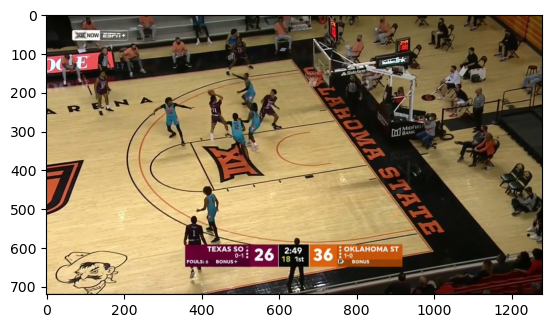

In [17]:
dataset_dicts = my_dataset_function()
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())